<a href="https://colab.research.google.com/github/AlexanderMATI/FilmML/blob/main/Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [212]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline 

In [213]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score


In [214]:
df = pd.read_csv("/content/film (20).tsv")
df.tail()

,id,Title,Release_Year,Genre,Synopsis
1161,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...
1162,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...
1163,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...
1164,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...
1165,1165,Ненавижу,2016,драма,"Елена Аросьева («Чужое счастье», «Беловодье. Т..."


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1166 non-null   int64 
 1   Title         1166 non-null   object
 2   Release_Year  1166 non-null   object
 3   Genre         1166 non-null   object
 4   Synopsis      1166 non-null   object
dtypes: int64(1), object(4)
memory usage: 45.7+ KB


In [216]:
df['Genre']=df['Genre'].replace('unknown',np.nan)
df=df.dropna(axis=0, subset=['Genre'])
print(df.tail())

        id  ...                                           Synopsis
1161  1161  ...  Как часто любовное приключение приводит нас к ...
1162  1162  ...  Девятилетний Андрей живёт без родительской люб...
1163  1163  ...  Фильм-продолжение советской трагикомедия «Белы...
1164  1164  ...  Отечественный мини-сериал «Знахарка» поведает ...
1165  1165  ...  Елена Аросьева («Чужое счастье», «Беловодье. Т...

[5 rows x 5 columns]


In [217]:
print(len(df))
print(df.shape)
a=df['Genre'].value_counts()[:20]
b=a.keys().tolist()
print(b)
df=df[df.Genre.isin(b)]
df=df.reset_index(drop=True)

1166
(1166, 5)
['драма', 'комедия', 'документальный', 'военный', 'детектив', 'боевик', 'приключения', 'Для детей', 'криминал', 'биография', 'триллер', 'ужасы', 'фантастика', 'фэнтези', 'семейный', 'Артхаус', 'музыка', 'Спорт', 'мультфильм', 'Зарубежные']


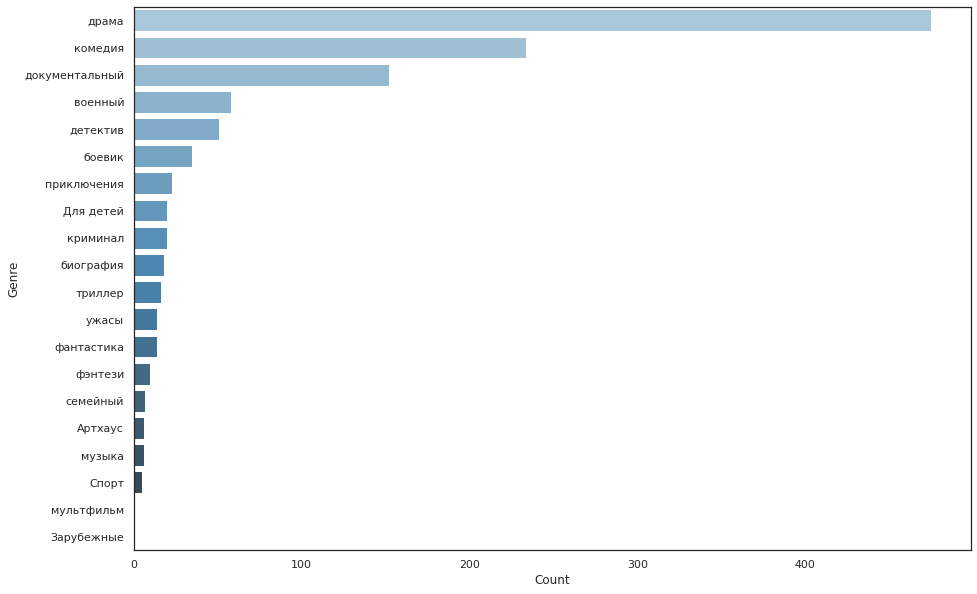

In [218]:
sns.set(style="white")
genre_to_count=pd.DataFrame({'Genre':a.index, 'Count':a.values})
plt.figure(figsize=(15,10))
sns.barplot(y="Genre", x="Count", data=genre_to_count,palette="Blues_d")


,Genre,Genre_cnt
0,драма,475
1,комедия,234
2,документальный,152
3,военный,58
4,детектив,51
5,боевик,35
6,приключения,23
7,Для детей,20
8,криминал,20
9,биография,18


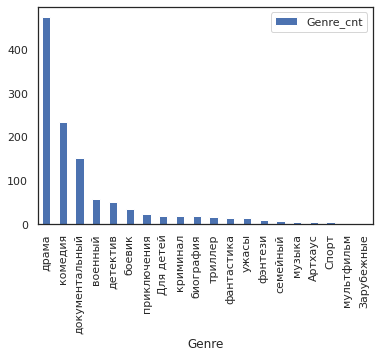

In [219]:
genre_count_df = df[['id','Genre']].groupby('Genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'Genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'Genre_cnt', x = 'Genre')

genre_count_df

In [220]:
df = df.merge(genre_count_df, how = 'left', left_on='Genre', right_on='Genre')

df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...,475
1,1,Судьба человека,1959,военный,"Кинодебют Сергея Бондарчука – режиссера, экран...",58
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...,475
3,3,Брат 2,2000,криминал,Легендарную фразу Данилы Багрова «Скоро всей в...,20
4,4,Легенда №17,2012,Спорт,Данила Козловский и Олег Меньшиков в спортивно...,5
...,...,...,...,...,...,...
1161,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...,475
1162,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...,475
1163,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...,234
1164,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...,475


In [221]:
GENRE_CNT_MIN = 150

df = df [df['Genre_cnt'] > GENRE_CNT_MIN]

df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...,475
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...,475
5,5,Тот самый Мюнхгаузен,1979,комедия,Одна из самых ярких и запоминающихся ролей выд...,234
7,7,Республика ШКИД,1966,комедия,"Знаменитая картина ""Республика ШКИД"" рассказыв...",234
8,8,Человек с бульвара Капуцинов,1987,драма,Комедийный вестерн от создателей «Будьте моим ...,475
...,...,...,...,...,...,...
1161,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...,475
1162,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...,475
1163,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...,234
1164,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...,475


In [222]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [223]:
def plotToWords(raw_plot):
    letters_only = re.sub("[^а-яА-Я]", " ", str(raw_plot))
    lower_case = letters_only.lower()
    words = lower_case.split()
    stops = set(stopwords.words("russian"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

def preprocess(dataframe):
    clean_train_reviews = []
    for i in range(0,len(dataframe)):
        clean_train_reviews.append(plotToWords(dataframe.iloc[i]['Synopsis']))
    dataframe['Synopsis']=clean_train_reviews
    return dataframe

df=preprocess(df)
print(df["Synopsis"][:10])

0     культовая советская драма режиссера андрея сми...
2     сотрудницы почтового отделения собираются вмес...
5     одна самых ярких запоминающихся ролей выдающег...
7     знаменитая картина республика шкид рассказывае...
8     комедийный вестерн создателей будьте моим муже...
9     судьба родина едины пели красавца хором волнов...
10    визитная карточка режиссера владимира меньшова...
11    знаменитая советская комедия собравшая поистин...
12    нашем кинотеатре найдете большое собрание сове...
15    история жизни анатолия крупнова одного самых в...
Name: Synopsis, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=4000)
features = tfidf.fit_transform(df.Synopsis).toarray()
labels = df.Genre
features.shape

(861, 4000)

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Synopsis'], df['Genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [226]:
print(clf.predict(count_vect.transform(["Новая история происходит в вымышленном городе Южная Верона, где Монтекки и Капулетти становятся Кампелос и Монтейрос - двумя враждующими семьями, известными всему городу. Однако на этом сходство с оригинальной историей заканчивается. Ромео и Джульетта становятся Ромуло и Рамоном и впитывают черты характера обоих классических персонажей, давая новую жизнь известному сюжету."])))

['драма']


In [227]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(max_iter=150000),
    MultinomialNB(),
    LogisticRegression(random_state=0,max_iter=150000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [228]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.800269
LogisticRegression    0.724755
MultinomialNB         0.689891
Name: accuracy, dtype: float64